In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer/Customers.csv


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')


In [12]:
df = pd.read_csv("/kaggle/input/customer/Customers.csv")
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset shape: (10000, 12)

First 5 rows:


,customer_ID,Contact_Last_Name,Contact_First_Name,Street,City,State,Zip,Country,Age,Marital_Status,Gender,Number_Of_Dependents
0,1,Chaney,Jemima,5584 Orci Street,Lexington,Kentucky,36751,United States,65,Married,Male,0
1,2,Collins,Colt,"P.O. Box 643, 8508 At, St.",Boston,Massachusetts,25388,United States,65,Married,Male,0
2,3,Crawford,Glenna,"P.O. Box 890, 8204 Lectus Rd.",Milwaukee,Wisconsin,33343,United States,65,NaN,Male,0
3,4,Fisher,Sophia,Ap #274-5091 Vel Avenue,Salem,Oregon,90464,United States,65,Married,Female,0
4,5,Gonzales,Evan,798-923 Ante Street,Olympia,Washington,82930,United States,65,Married,Female,0


In [13]:
print("Dataset Info:")
df.info()
print("\nMissing values count:")
print(df.isnull().sum())
print("\nMissing values percentage:")
print((df.isnull().sum() / len(df)) * 100)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   customer_ID           10000 non-null  int64 
 1   Contact_Last_Name     10000 non-null  object
 2   Contact_First_Name    10000 non-null  object
 3   Street                10000 non-null  object
 4   City                  10000 non-null  object
 5   State                 10000 non-null  object
 6   Zip                   10000 non-null  int64 
 7   Country               10000 non-null  object
 8   Age                   10000 non-null  int64 
 9   Marital_Status        8111 non-null   object
 10  Gender                9010 non-null   object
 11  Number_Of_Dependents  10000 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 937.6+ KB

Missing values count:
customer_ID                0
Contact_Last_Name          0
Contact_First_Name         0
Street          

In [14]:
# Identify ID columns that shouldn't be used for modeling
id_cols = ["CustomerID", "Name", "Email"]  # Adjust based on your dataset

# Get categorical columns (excluding ID columns)
cat_cols = [col for col in df.select_dtypes(include=['object']).columns if col not in id_cols]
print("Categorical columns to encode:", cat_cols)

# Create a copy for encoding
df_encoded = df.copy()

# Encode categorical columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = df_encoded[col].astype(str)  # Convert NaN to 'nan' string
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le
    print(f"Encoded {col}: {le.classes_}")

Categorical columns to encode: ['Contact_Last_Name', 'Contact_First_Name', 'Street', 'City', 'State', 'Country', 'Marital_Status', 'Gender']
Encoded Contact_Last_Name: ['Abbott' 'Acevedo' 'Acosta' 'Adams' 'Adkins' 'Aguilar' 'Aguirre' 'Albert'
 'Alexander' 'Alford' 'Allen' 'Allison' 'Alston' 'Alvarado' 'Alvarez'
 'Anderson' 'Andrews' 'Anthony' 'Armstrong' 'Arnold' 'Ashley' 'Atkins'
 'Atkinson' 'Austin' 'Avery' 'Avila' 'Ayala' 'Ayers' 'Bailey' 'Baird'
 'Baker' 'Baldwin' 'Ball' 'Ballard' 'Banks' 'Barber' 'Barker' 'Barlow'
 'Barnes' 'Barnett' 'Barr' 'Barrera' 'Barrett' 'Barron' 'Barry' 'Bartlett'
 'Barton' 'Bass' 'Bates' 'Battle' 'Bauer' 'Baxter' 'Beach' 'Bean' 'Beard'
 'Beasley' 'Beck' 'Becker' 'Bell' 'Bender' 'Benjamin' 'Bennett' 'Benson'
 'Bentley' 'Benton' 'Berg' 'Berger' 'Bernard' 'Berry' 'Best' 'Bird'
 'Bishop' 'Black' 'Blackburn' 'Blackwell' 'Blair' 'Blake' 'Blanchard'
 'Blankenship' 'Blevins' 'Bolton' 'Bond' 'Bonner' 'Booker' 'Boone' 'Booth'
 'Bowen' 'Bowers' 'Bowman' 'Boyd' 'Boyer

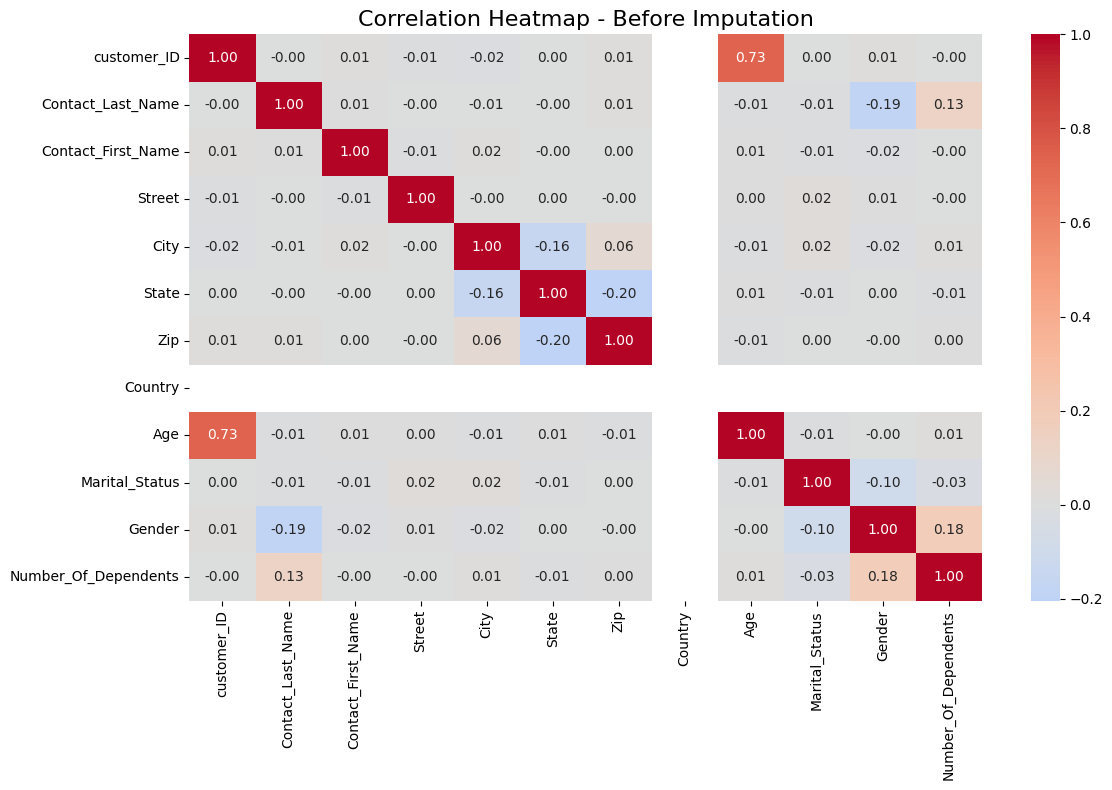


Correlation with Marital_Status:
Marital_Status          1.000000
City                    0.022951
Street                  0.018293
Zip                     0.002673
customer_ID             0.000243
Age                    -0.008524
State                  -0.009247
Contact_First_Name     -0.010710
Contact_Last_Name      -0.012093
Number_Of_Dependents   -0.034665
Gender                 -0.097456
Country                      NaN
Name: Marital_Status, dtype: float64

Correlation with Gender:
Gender                  1.000000
Number_Of_Dependents    0.183886
customer_ID             0.008582
Street                  0.007011
State                   0.001063
Zip                    -0.004453
Age                    -0.004489
Contact_First_Name     -0.016660
City                   -0.017657
Marital_Status         -0.097456
Contact_Last_Name      -0.193810
Country                      NaN
Name: Gender, dtype: float64


In [15]:
plt.figure(figsize=(12, 8))
corr_matrix = df_encoded.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap - Before Imputation", fontsize=16)
plt.tight_layout()
plt.show()

# Show correlations with missing value columns
missing_cols = [col for col in cat_cols if df[col].isnull().any()]
for col in missing_cols:
    if col in corr_matrix.columns:
        print(f"\nCorrelation with {col}:")
        print(corr_matrix[col].sort_values(ascending=False))

In [16]:
def fill_missing_values(df, target_col, model_type="rf", encoders=None):
    """
    Fill missing values using Random Forest or XGBoost
    """
    nan_label = encoders[target_col].transform(['nan'])[0]
    known = df[df[target_col] != nan_label].copy()
    unknown = df[df[target_col] == nan_label].copy()
    
    if unknown.empty:
        print(f"No missing values in {target_col}")
        return df, 0
    
    print(f"\nFilling {len(unknown)} missing values in {target_col} using {model_type.upper()}")
    
    # Prepare features and target
    feature_cols = [col for col in df.columns if col != target_col and col not in id_cols]
    X = known[feature_cols]
    y = known[target_col]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )
    
    # Initialize model
    if model_type == "rf":
        model = RandomForestClassifier(
            n_estimators=200, 
            random_state=42,
            n_jobs=-1
        )
    else:  # XGBoost
        model = XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            use_label_encoder=False,
            eval_metric="mlogloss",
            n_jobs=-1
        )
    
    # Train model
    model.fit(X_train, y_train)
    
    # Evaluate model
    accuracy = model.score(X_test, y_test)
    print(f"{target_col} - {model_type.upper()} Accuracy: {accuracy:.4f}")
    
    # Predict missing values
    predictions = model.predict(unknown[feature_cols])
    
    # Create result dataframe
    df_result = df.copy()
    df_result.loc[unknown.index, target_col] = predictions
    
    return df_result, accuracy

In [17]:
# Get columns with missing values
missing_columns = [col for col in cat_cols if df[col].isnull().any()]
print("Columns with missing values:", missing_columns)

# Dictionary to store results
imputation_results = {}
best_filled_df = df_encoded.copy()

for col in missing_columns:
    print(f"\n{'='*50}")
    print(f"Processing column: {col}")
    print(f"{'='*50}")
    
    # Test Random Forest
    df_rf, acc_rf = fill_missing_values(df_encoded, col, "rf", encoders)
    
    # Test XGBoost
    df_xgb, acc_xgb = fill_missing_values(df_encoded, col, "xgb", encoders)
    
    # Choose best model
    if acc_rf >= acc_xgb:
        best_model = "Random Forest"
        best_accuracy = acc_rf
        best_filled_df = df_rf.copy()
    else:
        best_model = "XGBoost"
        best_accuracy = acc_xgb
        best_filled_df = df_xgb.copy()
    
    imputation_results[col] = {
        'rf_accuracy': acc_rf,
        'xgb_accuracy': acc_xgb,
        'best_model': best_model,
        'best_accuracy': best_accuracy
    }
    
    print(f"\nBest model for {col}: {best_model} (Accuracy: {best_accuracy:.4f})")


Columns with missing values: ['Marital_Status', 'Gender']

Processing column: Marital_Status

Filling 1889 missing values in Marital_Status using RF
Marital_Status - RF Accuracy: 0.5773

Filling 1889 missing values in Marital_Status using XGB
Marital_Status - XGB Accuracy: 0.5903

Best model for Marital_Status: XGBoost (Accuracy: 0.5903)

Processing column: Gender

Filling 990 missing values in Gender using RF
Gender - RF Accuracy: 0.8252

Filling 990 missing values in Gender using XGB
Gender - XGB Accuracy: 0.8352

Best model for Gender: XGBoost (Accuracy: 0.8352)


In [18]:
print("\n" + "="*70)
print("IMPUTATION RESULTS SUMMARY")
print("="*70)

results_df = pd.DataFrame(imputation_results).T
results_df = results_df.round(4)
print(results_df)



IMPUTATION RESULTS SUMMARY
               rf_accuracy xgb_accuracy best_model best_accuracy
Marital_Status    0.577326     0.590265    XGBoost      0.590265
Gender            0.825194     0.835183    XGBoost      0.835183


In [19]:
# Decode categorical columns back to original values
df_final = best_filled_df.copy()
for col, encoder in encoders.items():
    df_final[col] = encoder.inverse_transform(df_final[col])

# Verify no missing values remain
print("\nMissing values after imputation:")
print(df_final.isnull().sum())

# Add non-encoded columns back
for col in id_cols:
    if col in df.columns:
        df_final[col] = df[col]

# Save the cleaned dataset
df_final.to_csv("Customers_cleaned.csv", index=False)
print(f"\nCleaned dataset saved as 'Customers_cleaned.csv'")
print(f"Final dataset shape: {df_final.shape}")


Missing values after imputation:
customer_ID             0
Contact_Last_Name       0
Contact_First_Name      0
Street                  0
City                    0
State                   0
Zip                     0
Country                 0
Age                     0
Marital_Status          0
Gender                  0
Number_Of_Dependents    0
dtype: int64

Cleaned dataset saved as 'Customers_cleaned.csv'
Final dataset shape: (10000, 12)


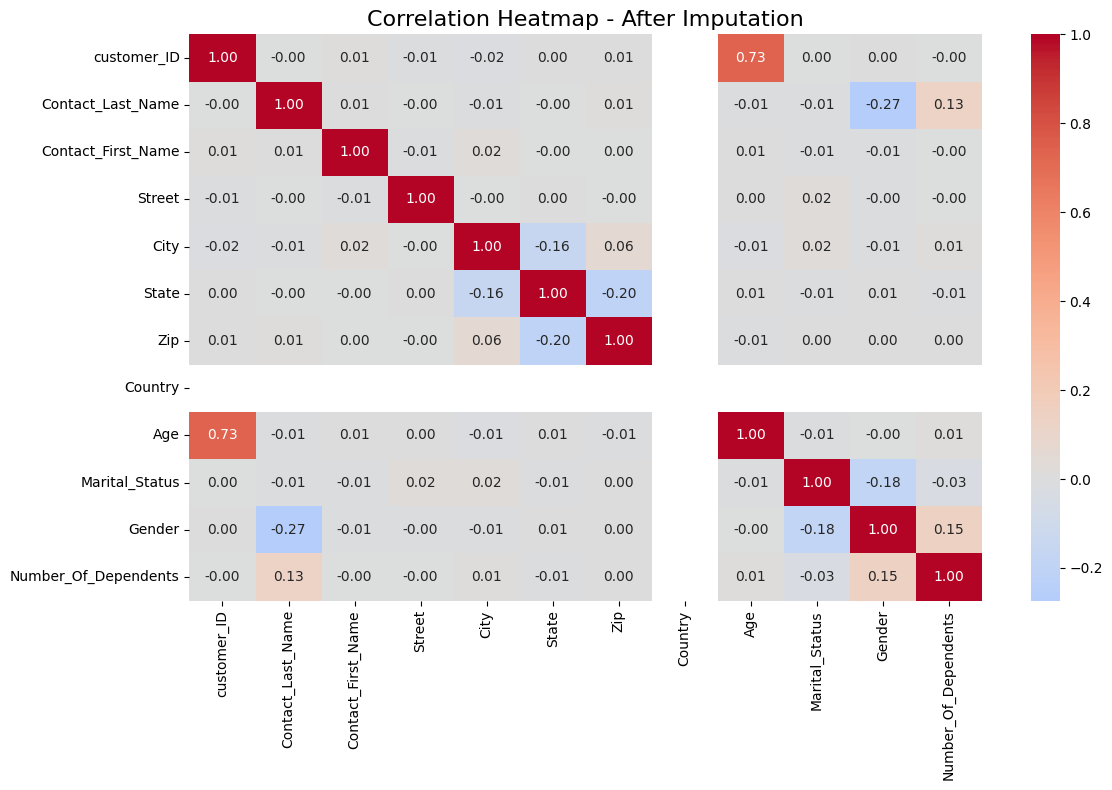


BEFORE vs AFTER COMPARISON:
----------------------------------------
Original dataset missing values:
Marital_Status: 1889 → 0
Gender: 990 → 0

Total missing values: 2879 → 0


In [20]:
# Encode final dataset for correlation analysis
df_final_encoded = df_final.copy()
for col in cat_cols:
    if col in df_final_encoded.columns:
        le = LabelEncoder()
        df_final_encoded[col] = le.fit_transform(df_final_encoded[col].astype(str))

plt.figure(figsize=(12, 8))
final_corr = df_final_encoded.corr(numeric_only=True)
sns.heatmap(final_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap - After Imputation", fontsize=16)
plt.tight_layout()
plt.show()

# Cell 10: Before vs After Comparison
print("\nBEFORE vs AFTER COMPARISON:")
print("-" * 40)
print("Original dataset missing values:")
for col in missing_columns:
    original_missing = df[col].isnull().sum()
    final_missing = df_final[col].isnull().sum()
    print(f"{col}: {original_missing} → {final_missing}")

print(f"\nTotal missing values: {df.isnull().sum().sum()} → {df_final.isnull().sum().sum()}")